In [1]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.3 MB/s eta 0:00:00


In [2]:
import boto3
import botocore
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from random import randint
from google.colab import drive
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications import EfficientNetB0

In [3]:
# Defining functions for updating git files
def runcmd(command):
  res = subprocess.run(command, shell=True, capture_output=True, text=True)
  print(res.stdout, res.stderr)

def copytogit():
  source = "drive/MyDrive/Colab\ Notebooks/colab_createmodel.ipynb"
  dest = "github-private-learning/"
  res = subprocess.run(
      "cp %s %s" % (source, dest),
      cwd="/content",
      shell=True,
      capture_output=True,
      text=True
  )
  print(res.stdout, res.stderr)

def commitandpush(comment):
  runcmd("git add -u")
  runcmd("git commit -m \"%s\"" % comment)
  runcmd("git push origin main")

In [4]:
# Connect to GitHub for Colab
email = input("Input GitHub Email: ")
username = input("Input GitHub Username: ")
github_token = input("Access Token: ")
clear_output()

runcmd("git config --global user.email \"%s\"" % email)
runcmd("git config --global user.name \"%s\"" % username)
!git clone https://github.com/NahcoCZ/github-private-learning.git
%cd github-private-learning/
runcmd("git remote add origin https://%s:%s@github.com/NahcoCZ/github-private-learning.git" % (username, github_token))
runcmd("git remote set-url origin https://%s:%s@github.com/NahcoCZ/github-private-learning.git" % (username, github_token))

 
 
Cloning into 'github-private-learning'...
remote: Enumerating objects: 11764, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 11764 (delta 29), reused 53 (delta 10), pack-reused 11691
Receiving objects: 100% (11764/11764), 394.27 MiB | 31.46 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (11739/11739), done.
/content/github-private-learning
 fatal: remote origin already exists.

 


In [5]:
# Connect to google drive to update files
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Download the data files from AWS S3 Bucket if needed
session = boto3.Session(
    aws_access_key_id=input("Access Key: "),
    aws_secret_access_key=input("Secret Key: "),
    aws_session_token=input("Session Token: ")
)
s3 = session.client('s3')

# Clear output to prevent AWS credential leak
clear_output()

try:
    s3.download_file("lolipoppers-project", "npy/image_data.npy", "image_data.npy")
    s3.download_file("lolipoppers-project", "npy/label_data.npy", "label_data.npy")
    print('File downloaded successfully.')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '404':
        print('The file does not exist.')
    else:
        print('An error occurred while downloading the file:', e)

An error occurred while downloading the file: An error occurred (400) when calling the HeadObject operation: Bad Request


In [7]:
# Load downloaded data into numpy.ndarray
X = np.load("/content/drive/MyDrive/Research Methodology/image_data.npy")
Y = np.load("label_data.npy")

# Declare label names and declaring functions for later use
label_names = [
    'Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney',
    'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair',
    'Traffic Light'
]


def decodeDataset(coded):
    return label_names[np.argmax(coded, axis=1)]


def decode(label):
    return label_names[np.argmax(label)]


def plotImage(img, label):
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(label)
    plt.imshow(img)
    plt.show()

In [8]:
# Split the training and testing data
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)

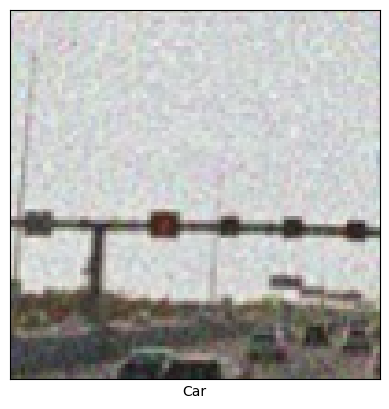

In [9]:
# Displaying one example from the dataset after splitting
plotImage(xtrain[0], decode(ytrain[0]))

In [14]:
# Defining compilation and training functions
def compile(model, epoch):
  # Compilation using adam optimization algorithm
  model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
  )
  history = model.fit(
    xtrain,
    ytrain,
    epochs=epoch,
    validation_data=(xtest, ytest)
  )
  return model, history

def setfigure():
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0, 1])
  plt.legend(loc='lower right')
  plt.show()

def evaluate(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  setfigure()

def checkmodel(model, epoch):
  result, hist = compile(model, epoch)
  evaluate(hist)
  test_loss, test_acc = result.evaluate(xtest, ytest, verbose=2)
  return result, hist

def comparegraph(hist1, hist2):
  hist = [hist1, hist2]
  for i in hist:
    plt.plot(i.history['accuracy'], label='accuracy')
  setfigure()

  for i in hist:
    plt.plot(i.history['val_accuracy'], label = 'val_accuracy')
  setfigure()

def compareacc(model1, model2):
  model1.evaluate(xtest, ytest, verbose=2)
  model2.evaluate(xtest, ytest, verbose=2)

In [ ]:
# Model Creation
firstModel = tf.keras.models.Sequential([
    # CNN Layers
    # 2D Convolution operation with 32 filters and 3x3 filter size
    # Smaller filter size will capture finer details on the image
    Conv2D(32, (3, 3), activation="relu", input_shape=(100, 100, 3)),
    # Max Pooling to reduce spatial dimension through 2x2 pooling window
    # Smaller pool size will capture more detail
    MaxPooling2D((2, 2)),
    # Adding more Convolution layers
    # filter count increased to capture more details and patterns
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((3, 3)),
    Conv2D(128, (3, 3), activation="relu"),
    # Convert to 1 dimensional array with Flatten
    Flatten(),
    # Use dense to capture the patterns and produce output
    Dense(64, activation="relu"),
    Dense(12)
])

In [ ]:
checkmodel(firstModel, 20)

Epoch 1/20
 38/294 [==>...........................] - ETA: 1:35 - loss: 1.5378 - accuracy: 0.2442

KeyboardInterrupt: ignored

In [ ]:
#Second model
second_model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(12)
])

In [ ]:
model2, history2 = checkmodel(second_model, 10)

In [ ]:
#Third model
third_model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(100, 100, 3)),
    Conv2D(32, (3, 3), activation="relu"),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(3, 3)),

    Conv2D(64, (3, 3), activation="relu"),
    Conv2D(64, (3, 3), activation="relu"),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(3, 3)),

    Conv2D(128, (3, 3), activation="relu"),
    Conv2D(128, (3, 3), activation="relu"),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2), strides=(3, 3)),

    # Conv2D(128, (3, 3), activation="relu"),
    # Conv2D(128, (3, 3), activation="relu"),
    # MaxPooling2D((2, 2), strides=(3, 3)),

    Flatten(),
    Dense(64, activation="relu"),
    Dense(12)
])
model3, history3 = checkmodel(third_model, 10)

In [ ]:
comparegraph(history2, history3)
compareacc(model2, model3)

Epoch 1/30
294/294 [==============================] - 74s 84ms/step - loss: 0.1431 - accuracy: 0.6922 - val_loss: 0.1165 - val_accuracy: 0.7604
Epoch 2/30
294/294 [==============================] - 30s 103ms/step - loss: 0.0806 - accuracy: 0.8284 - val_loss: 0.0841 - val_accuracy: 0.8316
Epoch 3/30
294/294 [==============================] - 24s 83ms/step - loss: 0.0653 - accuracy: 0.8641 - val_loss: 0.1023 - val_accuracy: 0.7988
Epoch 4/30
294/294 [==============================] - 23s 79ms/step - loss: 0.0602 - accuracy: 0.8793 - val_loss: 0.1016 - val_accuracy: 0.8061
Epoch 5/30
294/294 [==============================] - 24s 83ms/step - loss: 0.0401 - accuracy: 0.9186 - val_loss: 0.0970 - val_accuracy: 0.8227
Epoch 6/30
294/294 [==============================] - 23s 77ms/step - loss: 0.0332 - accuracy: 0.9346 - val_loss: 0.1260 - val_accuracy: 0.8082
Epoch 7/30
294/294 [==============================] - 25s 84ms/step - loss: 0.0318 - accuracy: 0.9381 - val_loss: 0.1217 - val_accuracy

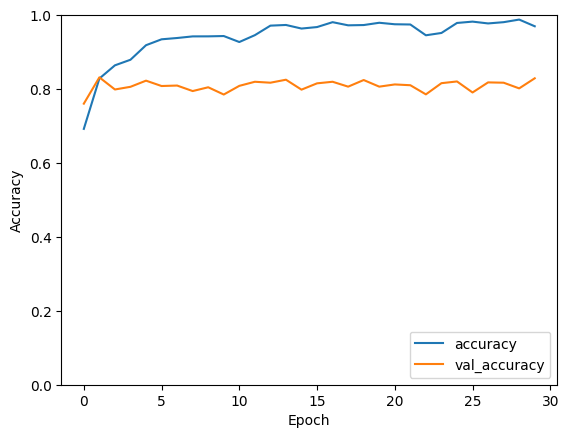

74/74 - 1s - loss: 0.1345 - accuracy: 0.8291 - 1s/epoch - 18ms/step


In [ ]:
# Model Creation

efficientnet_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(100, 100, 3))

timModel = tf.keras.models.Sequential([
    efficientnet_model,
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    BatchNormalization(),
    Flatten(),
    # Dense(64, activation="relu"),
    Dense(12, activation="softmax")
])
model4, history4 = checkmodel(timModel, 30)

In [11]:
# Model Creation


tim2Model = tf.keras.models.Sequential([
    Conv2D(64, (3, 3), activation="relu", input_shape=(100, 100, 3)),
    Conv2D(64, (3, 3), activation="relu"),
    # BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation="relu"),
    Conv2D(128, (3, 3), activation="relu"),
    # BatchNormalization(),
    # GlobalAveragePooling2D(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(256, (3, 3), activation="relu"),
    Conv2D(256, (3, 3), activation="relu"),
    GlobalAveragePooling2D(),
    # MaxPooling2D((3, 3)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.25),
    Dense(12, activation="softmax")
])
model5, history5 = checkmodel(tim2Model, 30)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 21/294 [=>............................] - ETA: 24:32 - loss: 0.4258 - accuracy: 0.1652

KeyboardInterrupt: ignored

In [ ]:
prediction = model4.predict(xtest)
testSize = int(input("input test size: "))
count = 0
random = randint(0, len(xtest) - testSize)
for i in range(random, random + testSize):
  pred = decode(prediction[i])
  real = decode(ytest[i])
  plotImage(xtest[i], "%s (pred) - %s (real)" % (pred, real))
  if pred == real:
    count = count + 1
print("acc = %f" % (count/testSize))

Output hidden; open in https://colab.research.google.com to view.

In [12]:
# Commit changes
copytogit()
commitandpush(input("Insert Commit Comment: "))

KeyboardInterrupt: ignored